# Homework 3: NumPy, Dask, and XGBoost

This notebook consolidates Parts 1–3 of the assignment into a single workflow. Run the cells in order on the Explorer OOD Jupyter environment after ensuring the required packages are installed.


## Environment Notes
- Recommended conda environment: `module load anaconda`, then create/activate one with NumPy, Dask, XGBoost, scikit-learn, python-docx, nycflights13.
- If packages are missing run: `pip install numpy dask[complete] distributed xgboost scikit-learn python-docx nycflights13`.
- Upload `train.csv` into the same directory as this notebook before starting Part 2.


In [1]:
import json
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dask.array as da
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster, performance_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

try:
    import xgboost as xgb
    from xgboost import dask as dxgb
    from xgboost import XGBClassifier
except ImportError as exc:  # pragma: no cover - import guard
    raise ImportError("Install xgboost with `pip install xgboost` before running Part 2.") from exc

try:
    from docx import Document
except ImportError:  # pragma: no cover - import guard
    Document = None
    print("python-docx is not installed; install it with `pip install python-docx` before running the reporting cell.")

plt.style.use("seaborn-v0_8")

SEED = 1
rng = np.random.default_rng(SEED)

part1_results = {}
part2_results = {"cpu_train_times": {}, "cpu_accuracy": {}, "dask_train_time": None, "dask_accuracy": None}
part3_results = {}

OUTPUT_DIR = Path.cwd()


## Part 1 – NumPy Array vs. Dask Array


### 1. NumPy Array Creation and Row Means
Use a fixed seed (1) and generate a 30,000 × 20,000 integer array with values in `[1, 10)`. The array is stored as `int16` to keep memory demands manageable while satisfying the requirement. A simple timer measures the time to compute row means.


In [2]:
ARRAY_SHAPE = (30000, 20000)
ARRAY_DTYPE = np.int16

start = time.perf_counter()
np_array = rng.integers(1, 10, size=ARRAY_SHAPE, dtype=ARRAY_DTYPE)
row_means_np = np_array.mean(axis=1)
elapsed = time.perf_counter() - start

part1_results["numpy_row_mean_seconds"] = elapsed

print(f"NumPy row means computed in {elapsed:.2f} seconds.")
print(f"Array dtype: {np_array.dtype}, total bytes: {np_array.nbytes / 1e9:.2f} GB")


NumPy row means computed in 2.52 seconds.
Array dtype: int16, total bytes: 1.20 GB


### 2. Convert to Dask Array with `(1000, 1000)` Chunks


In [3]:
chunk_shape = (1000, 1000)
da4 = da.from_array(np_array, chunks=chunk_shape, name="da4")
da4


dask.array<da4, shape=(30000, 20000), dtype=int16, chunksize=(1000, 1000), chunktype=numpy.ndarray>

### 3. Compare Byte Sizes for Array and Chunks
Use NumPy to compute expected byte sizes and compare them to Dask’s own metadata (`da4.nbytes`, chunk sizing).


In [4]:
array_bytes = np_array.nbytes
chunk_bytes_calc = int(np.prod(chunk_shape) * np_array.dtype.itemsize)

# Inspect Dask metadata
reported_array_bytes = da4.nbytes

# Derive one representative chunk shape from Dask's chunk structure
chunk_shapes = (da4.chunks[0][0], da4.chunks[1][0])
reported_chunk_bytes = int(np.prod(chunk_shapes) * np_array.dtype.itemsize)

comparison = {
    "numpy_array_bytes": array_bytes,
    "numpy_chunk_bytes": chunk_bytes_calc,
    "dask_array_bytes": reported_array_bytes,
    "dask_sample_chunk_bytes": reported_chunk_bytes,
}

part1_results["byte_size_comparison"] = comparison

print(json.dumps(comparison, indent=2))


{
  "numpy_array_bytes": 1200000000,
  "numpy_chunk_bytes": 2000000,
  "dask_array_bytes": 1200000000,
  "dask_sample_chunk_bytes": 2000000
}


### 4. Chunk Experiments & Timing
Time the Dask mean calculation for three chunk configurations, then visualize the runtime differences.


In [5]:
chunk_experiments = {
    "(1000, 1000)": (1000, 1000),
    "(3000, 2000)": (3000, 2000),
    "(300, 200)": (300, 200),
}

chunk_timings = {}
for label, chunk in chunk_experiments.items():
    darr = da.from_array(np_array, chunks=chunk)
    start = time.perf_counter()
    _ = darr.mean(axis=1).compute()
    elapsed = time.perf_counter() - start
    chunk_timings[label] = elapsed
    print(f"Chunk {label}: {elapsed:.2f} seconds")

part1_results["chunk_timings_seconds"] = chunk_timings


Chunk (1000, 1000): 0.33 seconds
Chunk (3000, 2000): 0.17 seconds
Chunk (300, 200): 5.03 seconds


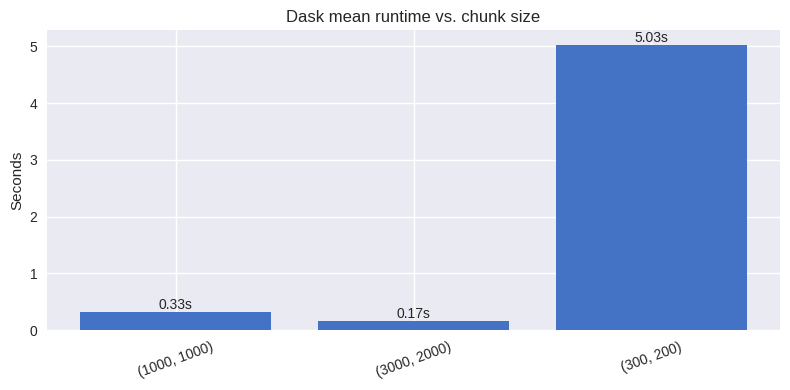

In [6]:
labels = list(chunk_timings.keys())
values = [chunk_timings[label] for label in labels]

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(labels, values, color="#4472c4")
ax.set_ylabel("Seconds")
ax.set_title("Dask mean runtime vs. chunk size")
for idx, val in enumerate(values):
    ax.text(idx, val, f"{val:.2f}s", ha="center", va="bottom")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


The most efficient chunking strategy balances parallelism and task overhead. Larger chunks reduce scheduling overhead but may strain memory; smaller chunks increase parallelism but incur more scheduler coordination.


## Part 2 – XGBoost Classification Workflow


### 1. Load `train.csv`
Ensure the dataset resides next to this notebook. If the file path differs, update `DATA_PATH` below.


In [7]:
DATA_PATH = Path("train.csv")
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Expected to find {DATA_PATH.resolve()} – upload the dataset before proceeding.")

raw_df = pd.read_csv(DATA_PATH)
print(f"Loaded dataset with shape: {raw_df.shape}")
raw_df.head()


Loaded dataset with shape: (61878, 95)


,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


### 2. Preprocess Features and Target
- Update `TARGET_COLUMN` if needed.
- Encodes string labels to integers when necessary.
- Splits data into training/testing sets.


In [8]:
TARGET_COLUMN = "target"  # Update if your dataset uses a different label column name.
if TARGET_COLUMN not in raw_df.columns:
    TARGET_COLUMN = raw_df.columns[-1]
    print(f"TARGET_COLUMN not found – defaulting to last column: {TARGET_COLUMN}")

feature_df = raw_df.drop(columns=[TARGET_COLUMN])
target_series = raw_df[TARGET_COLUMN]

label_encoder = None
if target_series.dtype == object:
    label_encoder = LabelEncoder()
    target_encoded = label_encoder.fit_transform(target_series)
else:
    target_encoded = target_series.to_numpy()

X = feature_df
y = pd.Series(target_encoded, name="target_encoded")

X_train_df, X_test_df, y_train_series, y_test_series = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=SEED,
    stratify=y,
)

num_classes = int(y.nunique())
objective = "binary:logistic" if num_classes == 2 else "multi:softprob"
print(f"Objective: {objective}; classes: {num_classes}")


Objective: multi:softprob; classes: 9


### 3. Train XGBoost with Varying CPU Counts
Measure training time for `n_jobs = {1, 2, 4, 8}` and collect accuracy for comparison.


In [9]:
def train_xgboost_cpu(n_jobs: int):
    params = dict(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective=objective,
        tree_method="hist",
        eval_metric="logloss",
        n_jobs=n_jobs,
        random_state=SEED,
    )
    if num_classes > 2:
        params["num_class"] = num_classes

    model = XGBClassifier(**params)
    start = time.perf_counter()
    model.fit(X_train_df, y_train_series)
    elapsed = time.perf_counter() - start

    y_pred = model.predict(X_test_df)
    acc = accuracy_score(y_test_series, y_pred)
    return model, elapsed, acc

cpu_options = [1, 2, 4, 8]
xgb_models = {}

for n_jobs in cpu_options:
    model, elapsed, acc = train_xgboost_cpu(n_jobs)
    xgb_models[n_jobs] = model
    part2_results["cpu_train_times"][n_jobs] = elapsed
    part2_results["cpu_accuracy"][n_jobs] = acc
    print(f"n_jobs={n_jobs}: {elapsed:.2f} seconds, accuracy={acc:.4f}")


n_jobs=1: 21.47 seconds, accuracy=0.9982
n_jobs=2: 11.57 seconds, accuracy=0.9982
n_jobs=4: 6.30 seconds, accuracy=0.9982
n_jobs=8: 6.37 seconds, accuracy=0.9982


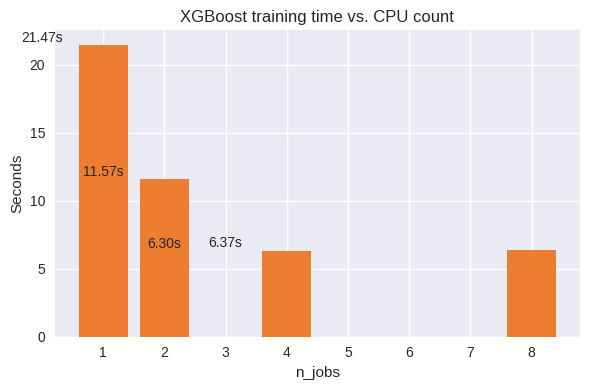

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(part2_results["cpu_train_times"].keys(), part2_results["cpu_train_times"].values(), color="#ed7d31")
ax.set_xlabel("n_jobs")
ax.set_ylabel("Seconds")
ax.set_title("XGBoost training time vs. CPU count")
for idx, (n_jobs, seconds) in enumerate(part2_results["cpu_train_times"].items()):
    ax.text(idx, seconds, f"{seconds:.2f}s", ha="center", va="bottom")
plt.tight_layout()
plt.show()


### 4. Provision Dask Distributed Scheduler (4 Cores, `processes=False`)
Create a local Dask cluster that mirrors the Explorer allocation of 4 cores with one thread per worker.


In [11]:
cluster = LocalCluster(
    n_workers=4,
    threads_per_worker=1,
    processes=False,
    scheduler_port=0,
    dashboard_address=":8787",
)
client = Client(cluster)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://10.99.249.84:8787/status,
Dashboard: http://10.99.249.84:8787/status,Workers: 4
Total threads: 4,Total memory: 48.00 GiB
Status: running,Using processes: False
Comm: inproc://10.99.249.84/278879/1,Workers: 0
Dashboard: http://10.99.249.84:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: inproc://10.99.249.84/278879/4,Total threads: 1
Dashboard: http://10.99.249.84:44975/status,Memory: 12.00 GiB
Nanny: None,


### 5. Train with Dask XGBoost and Compare Timing
Leverage the distributed scheduler with 4 workers and gather runtime plus accuracy for comparison against the pure CPU run with `n_jobs=4`.


In [12]:
dX_train = dd.from_pandas(X_train_df, npartitions=4)
dy_train = dd.from_pandas(y_train_series, npartitions=4)
dX_test = dd.from_pandas(X_test_df, npartitions=4)

params = {
    "objective": objective,
    "tree_method": "hist",
    "eta": 0.1,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "eval_metric": "logloss",
    "random_state": SEED,
}
if num_classes > 2:
    params["num_class"] = num_classes

start = time.perf_counter()
dtrain = dxgb.DaskDMatrix(client, dX_train, dy_train)
dask_output = dxgb.train(client, params, dtrain, num_boost_round=200)
dask_elapsed = time.perf_counter() - start
part2_results["dask_train_time"] = dask_elapsed
print(f"Dask XGBoost training completed in {dask_elapsed:.2f} seconds.")

booster = dask_output["booster"]
booster.set_param({"predictor": "cpu_predictor"})

X_test_np = X_test_df.to_numpy()
if objective == "binary:logistic":
    probas = booster.inplace_predict(X_test_np)
    y_pred = (probas > 0.5).astype(int)
else:
    probas = booster.inplace_predict(X_test_np)
    probas = probas.reshape(-1, num_classes)
    y_pred = np.argmax(probas, axis=1)

dask_acc = accuracy_score(y_test_series, y_pred)
part2_results["dask_accuracy"] = dask_acc
print(f"Dask XGBoost accuracy: {dask_acc:.4f}")

comparison_payload = {
    "cpu_n_jobs_4_seconds": part2_results["cpu_train_times"].get(4),
    "dask_seconds": dask_elapsed,
    "cpu_n_jobs_4_accuracy": part2_results["cpu_accuracy"].get(4),
    "dask_accuracy": dask_acc,
}
print(json.dumps(comparison_payload, indent=2))


/home/han.yus/.conda/envs/seanConda/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 71.76 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
[22:34:14] Task [xgboost.dask-1]:inproc://10.99.249.84/278879/6 got rank 1[22:34:14] Task [xgboost.dask-0]:inproc://10.99.249.84/278879/4 got rank 0
[22:34:14] Task [xgboost.dask-2]:inproc://10.99.249.84/278879/8 got rank 2

[22:34:14] Task [xgboost.dask-3]:inproc://10.99.249.84/278879/10 got rank 3


Dask XGBoost training completed in 17.38 seconds.


/home/han.yus/.conda/envs/seanConda/lib/python3.11/site-packages/xgboost/core.py:2864: UserWarning: [22:34:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


Dask XGBoost accuracy: 0.9984
{
  "cpu_n_jobs_4_seconds": 6.301404288038611,
  "dask_seconds": 17.378549398854375,
  "cpu_n_jobs_4_accuracy": 0.9982223658694247,
  "dask_accuracy": 0.9983839689722043
}


## Part 3 – NYC Flights `dep_delay` Analysis with Dask


### 1–3. Load, Clean, and Compute Statistics
Install `nycflights13` if needed, drop rows with missing `dep_delay`, and compute mean and standard deviation with a Dask client that uses four workers.


In [14]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33157")
client

<Client: 'tcp://127.0.0.1:33157' processes=4 threads=4, memory=48.00 GiB>

In [15]:
from nycflights13 import flights

flights_dd = dd.from_pandas(flights, npartitions=16)
clean_flights_dd = flights_dd.dropna(subset=["dep_delay"])

with performance_report(filename="dask_flights_report.html"):
    start = time.perf_counter()
    mean_future = clean_flights_dd["dep_delay"].mean()
    std_future = clean_flights_dd["dep_delay"].std()
    dep_delay_mean, dep_delay_std = dd.compute(mean_future, std_future)
    elapsed = time.perf_counter() - start

dep_delay_stats = pd.Series({"mean": dep_delay_mean, "std": dep_delay_std})

part3_results["dep_delay_stats"] = dep_delay_stats
part3_results["dask_runtime_seconds"] = elapsed

dep_delay_stats


/home/han.yus/.conda/envs/seanConda/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 43.31 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


mean    12.639070
std     40.210061
dtype: float64

### 4. Dashboard / Performance Capture


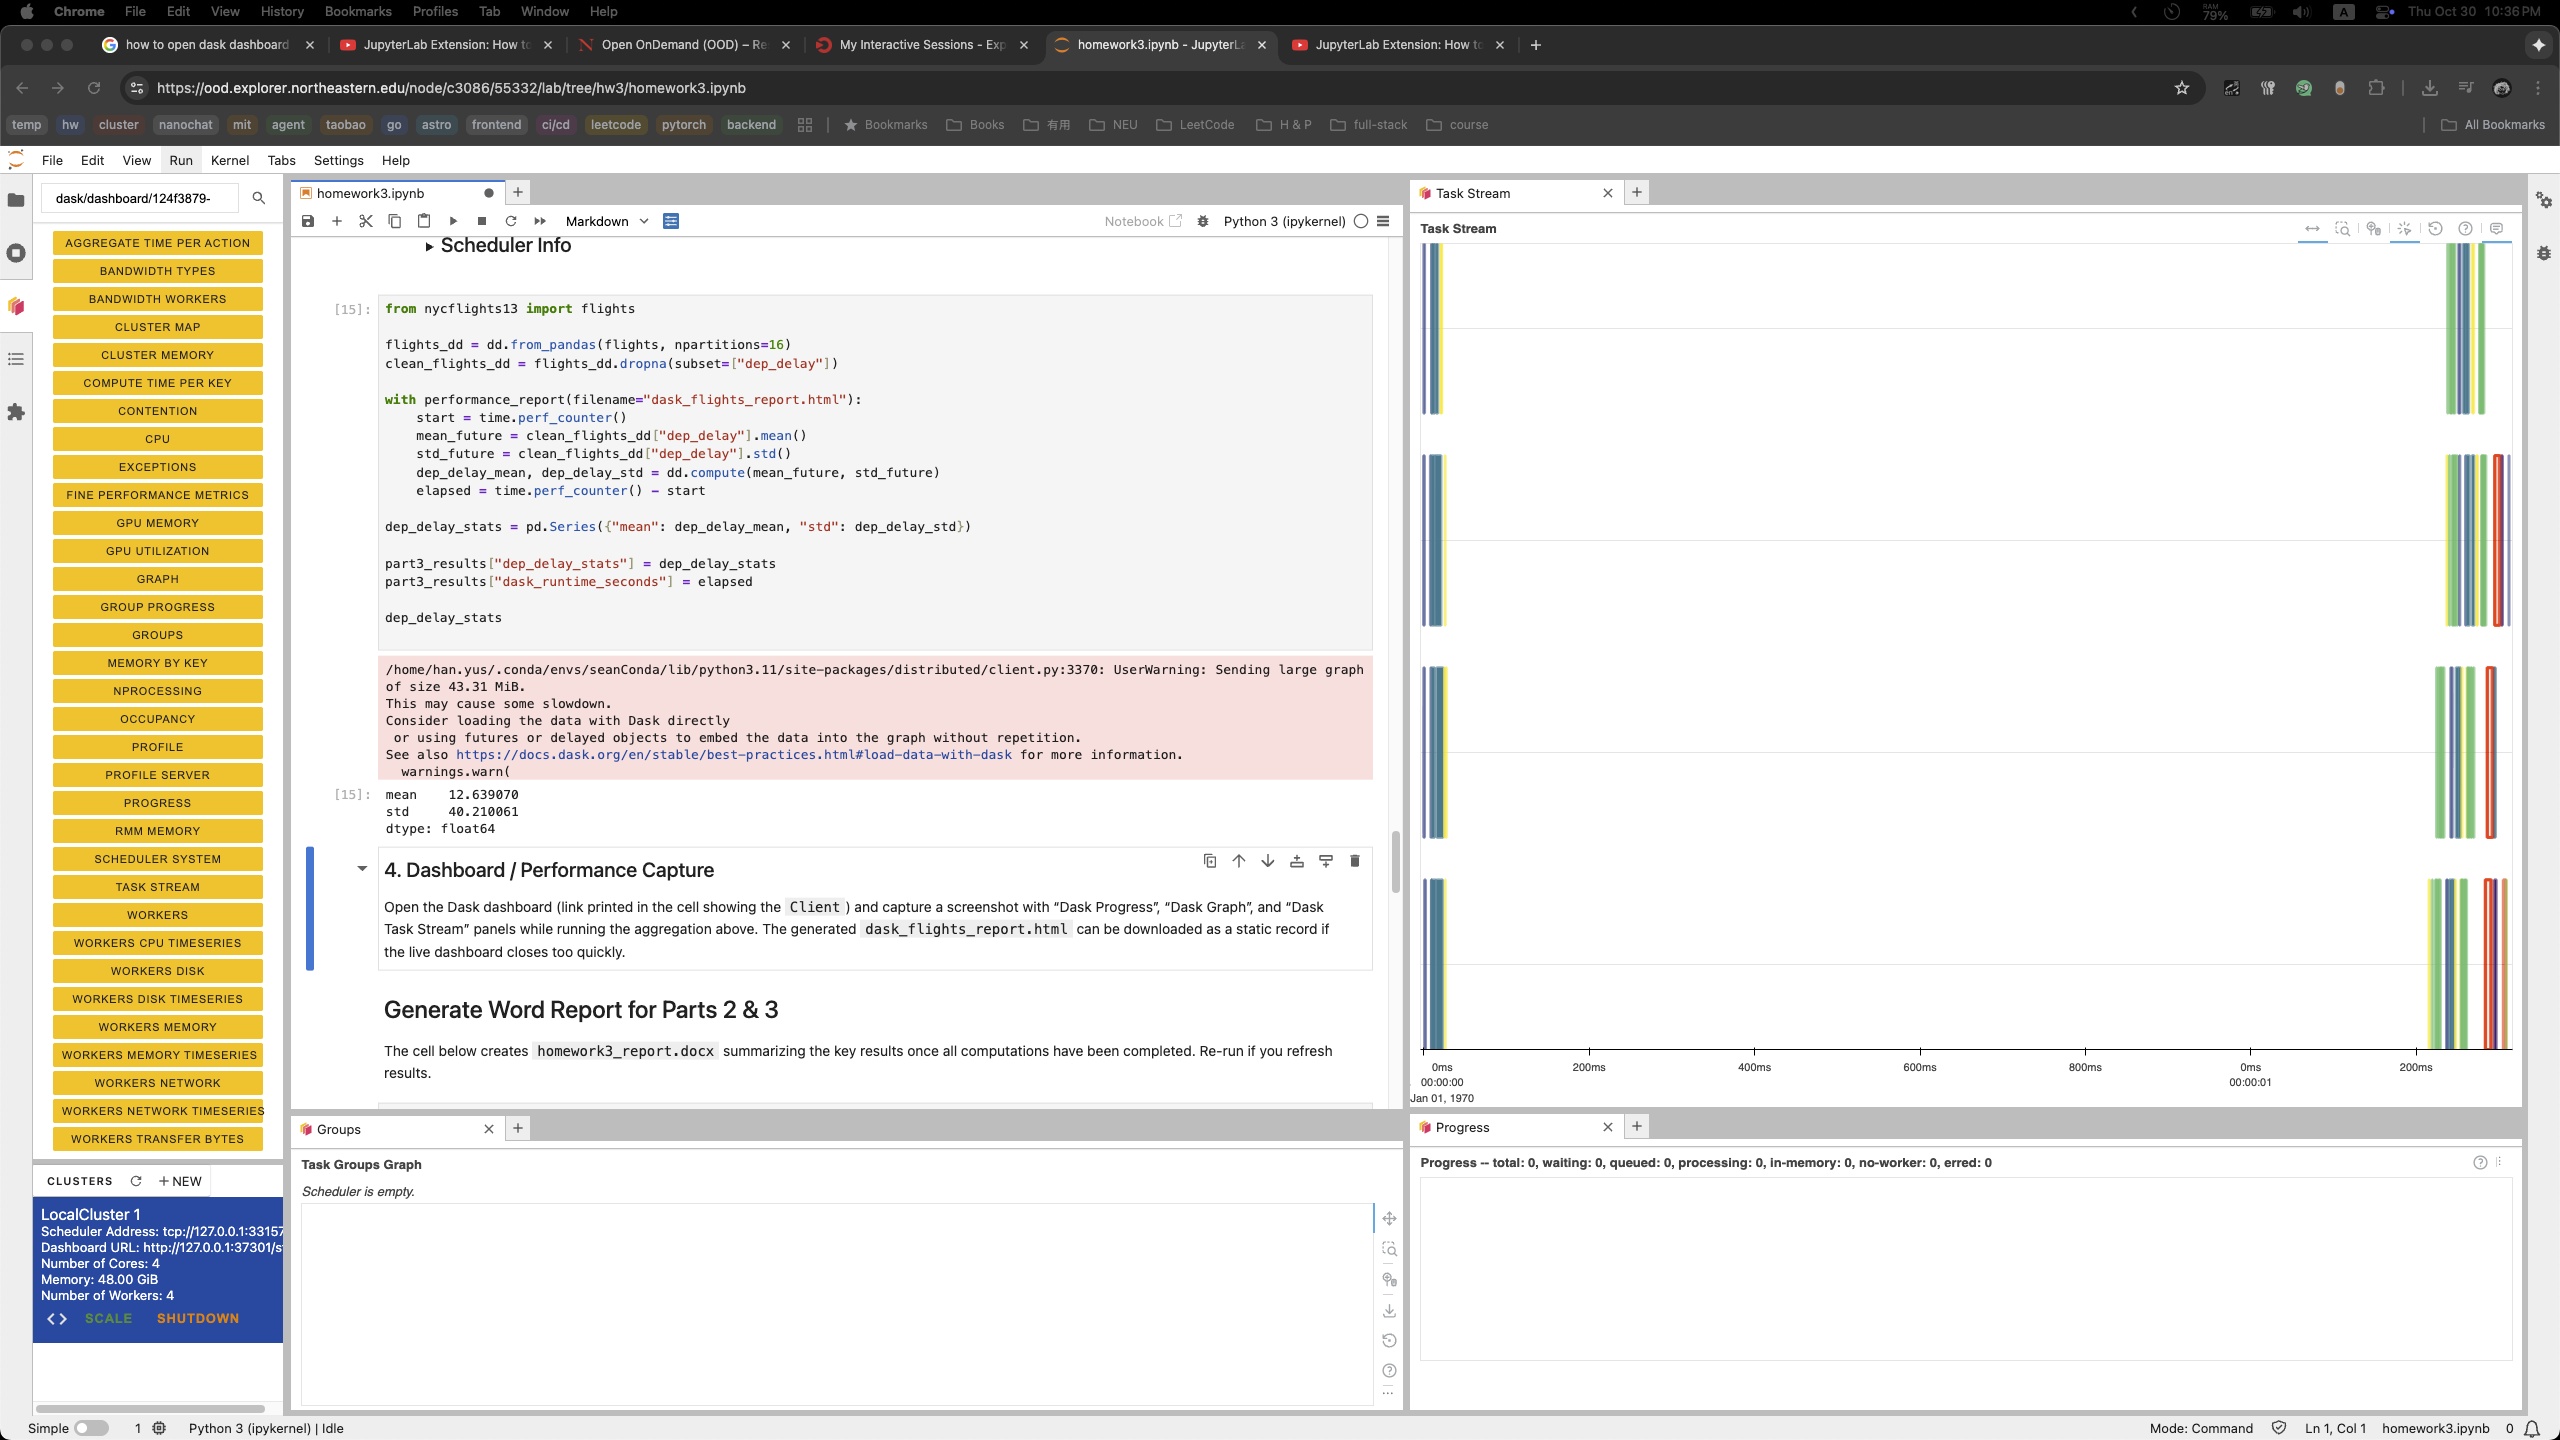

## Generate Word Report for Parts 2 & 3
The cell below creates `homework3_report.docx` summarizing the key results once all computations have been completed. Re-run if you refresh results.


In [16]:
if Document is None:
    raise RuntimeError("python-docx is unavailable – install it before generating the Word report.")

report_path = OUTPUT_DIR / "homework3_report.docx"
doc = Document()
doc.add_heading("Homework 3 Summary – Parts 2 & 3", level=1)

# Part 2 section
doc.add_heading("Part 2: XGBoost CPU vs. Dask", level=2)
para = doc.add_paragraph()
para.add_run("CPU baseline timings (seconds):\n").bold = True
for n_jobs, seconds in part2_results["cpu_train_times"].items():
    para.add_run(f"  n_jobs={n_jobs}: {seconds:.2f}s, accuracy={part2_results['cpu_accuracy'][n_jobs]:.4f}\n")

para = doc.add_paragraph()
para.add_run("Dask XGBoost (4 workers, 1 thread):\n").bold = True
para.add_run(
    f"  train time: {part2_results['dask_train_time']:.2f}s\n"
)
para.add_run(
    f"  accuracy: {part2_results['dask_accuracy']:.4f}\n"
)

if part2_results["cpu_train_times"].get(4) is not None:
    delta = part2_results["cpu_train_times"][4] - part2_results["dask_train_time"]
    doc.add_paragraph(f"Dask XGBoost speed-up vs. CPU n_jobs=4: {delta:.2f} seconds difference.")

# Part 3 section
doc.add_heading("Part 3: NYC Flights dep_delay Statistics", level=2)
para = doc.add_paragraph()
para.add_run("Summary statistics:\n").bold = True
para.add_run(f"  Mean departure delay: {part3_results['dep_delay_stats']['mean']:.2f} minutes\n")
para.add_run(f"  Std. deviation: {part3_results['dep_delay_stats']['std']:.2f} minutes\n")
para.add_run(f"  Dask computation time: {part3_results['dask_runtime_seconds']:.2f}s\n")

para = doc.add_paragraph("Dask performance report saved as dask_flights_report.html for documentation.")

doc.save(report_path)
print(f"Saved Word report to {report_path}")


Saved Word report to /home/han.yus/hw3/homework3_part2_part3.docx


## Results Summary Snapshot
Running the cell below dumps the collected metrics dictionary, which can also be serialized for future reference.


In [17]:
summary = {
    "part1": part1_results,
    "part2": part2_results,
    "part3": {
        "dep_delay_stats": part3_results.get("dep_delay_stats").to_dict() if part3_results.get("dep_delay_stats") is not None else None,
        "dask_runtime_seconds": part3_results.get("dask_runtime_seconds"),
    },
}
print(json.dumps(summary, indent=2, default=float))


{
  "part1": {
    "numpy_row_mean_seconds": 2.4260222781449556,
    "byte_size_comparison": {
      "numpy_array_bytes": 1200000000,
      "numpy_chunk_bytes": 2000000,
      "dask_array_bytes": 1200000000,
      "dask_sample_chunk_bytes": 2000000
    },
    "chunk_timings_seconds": {
      "(1000, 1000)": 0.4327260125428438,
      "(3000, 2000)": 0.17947344109416008,
      "(300, 200)": 7.307915102690458
    }
  },
  "part2": {
    "cpu_train_times": {
      "1": 22.32301738485694,
      "2": 12.639491679146886,
      "4": 8.744531078264117,
      "8": 7.899917276576161
    },
    "cpu_accuracy": {
      "1": 0.9982223658694247,
      "2": 0.9982223658694247,
      "4": 0.9982223658694247,
      "8": 0.9982223658694247
    },
    "dask_train_time": 21.588438112288713,
    "dask_accuracy": 0.9980607627666451
  },
  "part3": {
    "dep_delay_stats": {
      "mean": 12.639070257304708,
      "std": 40.21006089212995
    },
    "dask_runtime_seconds": 0.810818649828434
  }
}
